## モンテカルロ法による重点サンプリングと方策オフ型

In [1]:
%load_ext lab_black

In [2]:
import os
import sys

sys.path.insert(0, os.path.abspath("../../"))

import numpy as np
from collections import defaultdict
from common.gridworld import GridWorld

#### エージェントクラスの実装

In [3]:
def greedy_action_probs(Q, state, epsilon=0, action_size=4):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = np.argmax(qs)
    base_prob = epsilon / action_size
    action_probs = {
        action: base_prob for action in range(action_size)
    }  # {0: ε/4, 1: ε/4, 2: ε/4, 3: ε/4}
    action_probs[max_action] += 1 - epsilon
    return action_probs

In [4]:
class McAgent:
    def __init__(self):
        self.gamma = 0.9
        self.epsilon = 0.1
        self.alpha = 0.1
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        self.experience = []

    def get_action(self, state):
        ps = self.pi[state]
        actions, probs = list(ps.keys()), list(ps.values())
        return np.random.choice(actions, p=probs)

    def add(self, state, action, reward):
        self.experience.append((state, action, reward))

    def reset(self):
        self.experience.clear()

    def update(self):
        g = 0
        for data in reversed(self.experience):
            state, action, reward = data
            g = self.gamma * g + reward
            key = (state, action)
            self.Q[key] += (g - self.Q[key]) * self.alpha
            self.pi[state] = greedy_action_probs(self.Q, state, self.epsilon)

In [5]:
class McOffPolicyAgent(McAgent):
    def __init__(self):
        super().__init__()
        self.b = self.pi.copy()

    def get_action(self, state):
        ps = self.b[state]
        actions, probs = list(ps.keys()), list(ps.values())
        return np.random.choice(actions, p=probs)

    def update(self):
        g = 0
        rho = 1

        for data in reversed(self.experience):
            state, action, reward = data
            key = (state, action)

            g = self.gamma * rho * g + reward
            self.Q[key] += (g - self.Q[key]) * self.alpha
            rho *= self.pi[state][action] / self.b[state][action]

            self.pi[state] = greedy_action_probs(self.Q, state, epsilon=0)
            self.b[state] = greedy_action_probs(self.Q, state, self.epsilon)

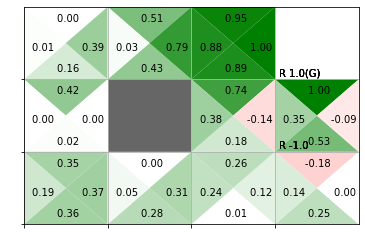

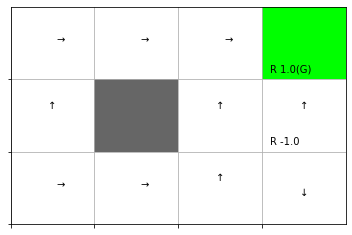

In [6]:
env = GridWorld()
agent = McOffPolicyAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.update()
            break

        state = next_state

env.render_q(agent.Q)